In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
import os

In [70]:
train_dir = 'original_images'



In [71]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

targetsize=96

batchsize=64

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(targetsize,targetsize),
        batch_size=batchsize,
        class_mode='categorical')


Found 5805 images belonging to 25 classes.


In [72]:
for data_batch, labels_batch in train_generator:
    print('data batch shape: ', data_batch.shape)
    print('labels batch shape: ', labels_batch.shape)
    break

data batch shape:  (64, 96, 96, 3)
labels batch shape:  (64, 25)


In [125]:
inputt,outputt = next(train_generator)

In [126]:
inputt.shape

(64, 96, 96, 3)

In [127]:
 inputt.shape==(batchsize,targetsize,targetsize,3)

True

In [75]:
outputt.shape

(64, 25)

In [76]:
inputt2=np.reshape(inputt,(batchsize,targetsize*targetsize*3))

In [77]:
inputt2.shape

(64, 27648)

In [84]:
# def load_data():
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
#     # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
#     # 784 columns per row
#     x_train = x_train.reshape(60000, 784)
#     return (x_train, y_train, x_test, y_test)
# (X_train, y_train,X_test, y_test)=load_data()
# print(X_train.shape)

def adam_optimizer():
    return adam(lr=0.0002, beta_1=0.5)

In [85]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=targetsize*targetsize*3, activation='sigmoid'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

g=create_generator()
g.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 27648)           

In [86]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=targetsize*targetsize*3))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

d =create_discriminator()
d.summary()



Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 1024)              28312576  
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_78 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 256)             

In [87]:
 def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_19 (Sequential)   (None, 27648)             29021952  
_________________________________________________________________
sequential_20 (Sequential)   (None, 1)                 28968961  
Total params: 57,990,913
Trainable params: 29,021,952
Non-trainable params: 28,968,961
_________________________________________________________________


In [106]:
def plot_generated_images(epoch, generator,  dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[batchsize, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(batchsize,targetsize,targetsize,3)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    #plt.savefig('gan_generated_image %d.png' %epoch)

In [128]:

def training(epochs=1, batch_size=batchsize):
    
    #Loading the data
    # batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in range(int(5805/batch_size)):
            if _%5==0:
                print(_/(58.05/batch_size),"%")
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # get next group of values
            inputt,outputt = next(train_generator)
            while inputt.shape!=(batch_size,targetsize,targetsize,3):
                inputt,outputt = next(train_generator)
                print(inputt.shape)
      
                    
            inputt2=np.reshape(inputt,(batch_size,targetsize*targetsize*3))
            
            # Get a random set of  real images
            
            image_batch = inputt2
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
 
           
        plot_generated_images(e, generator)





Epoch 1
0.0 %
5.512489233419466 %
11.024978466838933 %
16.5374677002584 %
22.049956933677866 %
27.56244616709733 %
33.0749354005168 %
38.587424633936266 %
44.09991386735573 %
49.6124031007752 %
55.12489233419466 %
60.63738156761413 %
66.1498708010336 %
71.66236003445306 %
77.17484926787253 %
82.68733850129199 %
88.19982773471146 %
(64, 96, 96, 3)
93.71231696813092 %


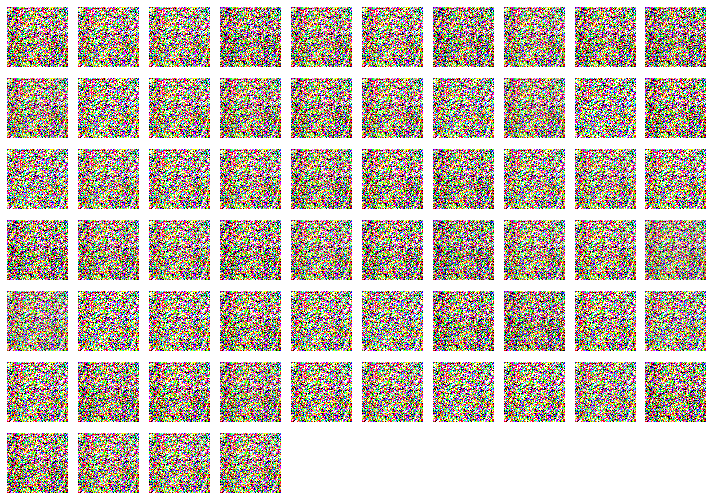

Epoch 2
0.0 %
5.512489233419466 %
11.024978466838933 %
16.5374677002584 %
22.049956933677866 %
27.56244616709733 %
33.0749354005168 %
38.587424633936266 %
44.09991386735573 %
49.6124031007752 %
55.12489233419466 %
60.63738156761413 %
66.1498708010336 %
71.66236003445306 %
77.17484926787253 %
82.68733850129199 %
88.19982773471146 %
(64, 96, 96, 3)
93.71231696813092 %


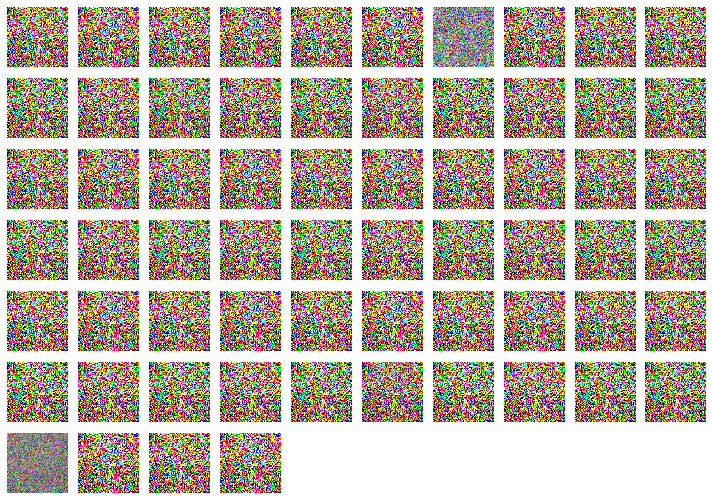

Epoch 3
0.0 %


In [ ]:
training(10)